In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
import sklearn.neighbors
from lib.scikitComponents import *
import itertools
import collections
from lib.scikitComponents import pipelines

## Data preprocessing

In [3]:
# Load in the previously created corpus and dictionary of scraped sites
#dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")

Done.


In [4]:
def merge_corpus(a, b):
    a = dict(a)
    b = dict(b)
    for k in b:
        old = a.get(k, 0)
        a[k] = old + b[k]
    return [(k, a[k]) for k in a]
merged_corpus = [merge_corpus(a, b) for a, b in zip(corpus, meta_corpus)]


In [5]:
"Empty documents: "+", ".join([str(i) for i, doc in enumerate(merged_corpus) if len(doc) < 5])

'Empty documents: 3, 5, 6, 7, 8, 58, 70, 128, 168, 206, 214, 363, 388, 425, 537, 581, 597, 615, 667, 675, 753, 761, 824, 862, 966, 1165, 1244, 1284, 1505, 1518, 1520, 1550, 1552, 1663, 1689, 1853, 2035, 2064, 2076, 2140, 2156, 2160, 2189, 2259, 2273, 2285, 2334'

In [6]:
# Set up array of input data
X = zip(list(corpus), list(meta_corpus), merged_corpus)
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Encode class labels
classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'])




verbosity = 0

## Get the scores of different combinations of classifiers

In [8]:
# Just TFIDF on metadata, LinearSVC
clf1 = pipelines.make_classifier(dictionary, corp_type='meta', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf1, X, classes, cv=5, verbose=verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.46 (+/- 0.07)


In [13]:
# Just word-count on metadata, LinearSVC
clf2 = pipelines.make_classifier(dictionary, feature='count', corp_type='meta', classifier='nb')
scores = sklearn.cross_validation.cross_val_score(clf2, X, classes, cv=5, verbose=verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.50 (+/- 0.05)


In [10]:
# Just TFIDF on body, LinearSVC
clf3 = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='body', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf3, X, classes, cv=5, verbose=verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.54 (+/- 0.06)


In [372]:
# Just LDA on body, LinearSVC
clf4 = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='body', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf4, X, classes, cv=5, verbose = verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.47 (+/- 0.07)


In [ ]:
"a"

In [7]:
# TFIDF on body and metadata, LinearSVC
clf5 = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf5, X, classes, cv=5, verbose = verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.57 (+/- 0.06)


In [11]:
# TFIDF on body and metadata, SGD
clf6 = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'sgd')
scores = sklearn.cross_validation.cross_val_score(clf6, X, classes, cv=5, verbose = verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.54 (+/- 0.05)


### Find good parameter for C

In [18]:
clf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc_gridsearch')
clf.fit(X, classes)
print clf.steps[2][1].best_estimator_
clf.steps[2][1].grid_scores_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.05 ..........................................................
[CV] ................................. C=0.05, score=0.549068 -   0.5s
[CV] C=0.05 ..........................................................
[CV] ................................. C=0.05, score=0.580726 -   0.5s
[CV] C=0.05 ..........................................................
[CV] ................................. C=0.05, score=0.525189 -   0.4s
[CV] C=0.08 ..........................................................
[CV] ................................. C=0.08, score=0.560248 -   0.4s
[CV] C=0.08 ..........................................................
[CV] ................................. C=0.08, score=0.585732 -   0.4s
[CV] C=0.08 ..........................................................
[CV] ................................. C=0.08, score=0.518892 -   0.4s
[CV] C=0.1 ...........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    7.3s finished



LinearSVC(C=0.08, class_weight='auto', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


[mean: 0.55171, std: 0.02275, params: {'C': 0.05},
 mean: 0.55505, std: 0.02754, params: {'C': 0.08},
 mean: 0.55254, std: 0.02854, params: {'C': 0.1},
 mean: 0.55129, std: 0.02921, params: {'C': 0.11},
 mean: 0.55004, std: 0.02898, params: {'C': 0.13}]

## Do some analysis on a single test/train split

### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some cases, indicating a moderate amount of success (given how naive this is!)

In [53]:
X_train, X_test, y_train, y_test, ind_train, ind_test = datastuff.tt_split(X, classes, test_size = 0.2)
clf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)


             precision    recall  f1-score   support

       arts       0.62      0.64      0.63        36
   business       0.55      0.51      0.53        41
  computers       0.70      0.73      0.71        63
      games       0.63      0.79      0.70        24
     health       0.76      0.79      0.78        33
       home       0.76      0.71      0.74        35
kids and teens       0.67      0.71      0.69        14
       news       0.61      0.73      0.67        30
 recreation       0.82      0.55      0.65        33
  reference       0.64      0.51      0.57        55
   regional       0.17      1.00      0.29         2
    science       0.57      0.63      0.60        46
   shopping       0.67      0.86      0.75        28
    society       0.65      0.29      0.40        45
     sports       0.83      0.91      0.87       115

avg / total       0.69      0.69      0.68       600



### Plot a confusion matrix

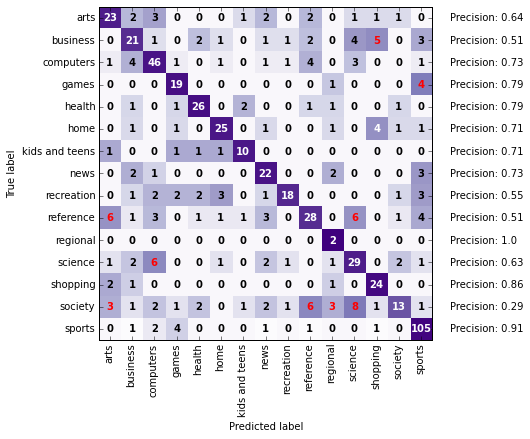

In [123]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, cmap=plt.cm.Purples)
#plt.savefig('confusion_tfidf-proportional-trees.pdf', bbox_inches='tight')
plt.show()

### Confusion matrix of the second guesses, first guess was wrong

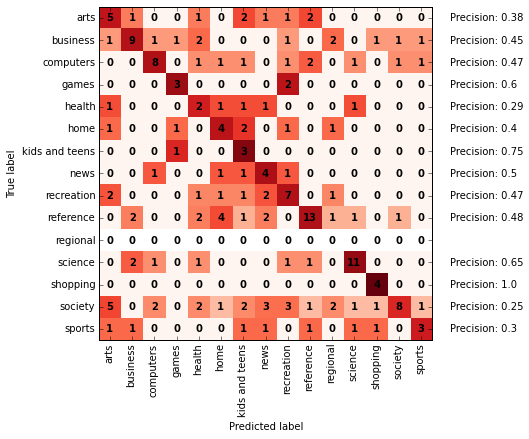

In [138]:
guesses = dmoz_encoder.inverse_transform(np.fliplr(np.argsort(clf.decision_function(X_test))))
real_labels = dmoz_encoder.inverse_transform(y_test)[y_test != predicted]
pred_labels = np.array([g[1] for g in guesses])[y_test != predicted]
cm = sklearn.metrics.confusion_matrix(real_labels, pred_labels, dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, showwarnings=False, cmap=plt.cm.Reds)
#plt.savefig('confusion_tfidf-proportional-trees.pdf', bbox_inches='tight')
plt.show()

### Confusion matrix of the second guesses, first guess was correct

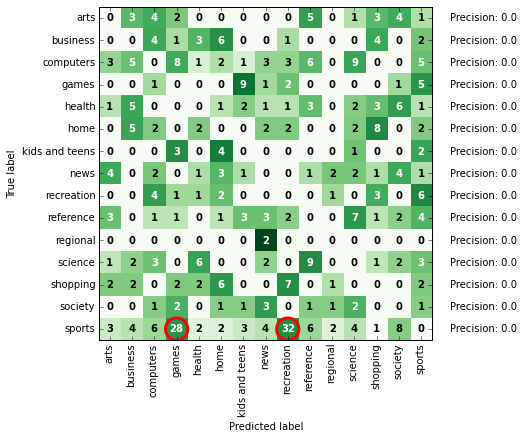

In [166]:
guesses = dmoz_encoder.inverse_transform(np.fliplr(np.argsort(clf.decision_function(X_test))))
real_labels = dmoz_encoder.inverse_transform(y_test)[y_test == predicted]
pred_labels = np.array([g[1] for g in guesses])[y_test == predicted]
cm = sklearn.metrics.confusion_matrix(real_labels, pred_labels, dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, showwarnings=False, cmap=plt.cm.Greens)

def draw_circle(pos, r=0.5, color='r', fill=False, linewidth=3):
    c = plt.Circle(pos, r, color=color, fill=fill, linewidth=linewidth)
    fig = plt.gcf()
    fig.gca().add_artist(c)
    
draw_circle((3, 14))
draw_circle((8, 14))

#plt.savefig('confusion_tfidf-proportional-trees.pdf', bbox_inches='tight')
#plt.scatter([1],[1])
#plt.xlim((-0.5, 14.5))
#plt.ylim((-0.5, 14.5))
plt.show()

### Look at the SVM coefficients for words

In [29]:
words = []
for c in range(14):
    weights = clf.steps[2][1].coef_[c]
    inds = np.argsort(weights)[::-1]
    best = [dictionary[i] for i in inds][:9]
    words.append(best)
    print "{{{}}}: {}".format(dmoz_encoder.inverse_transform(c), ", ".join(best))
#np.array(words)

{arts}: art, artist, design, costum, tattoo, award, latin, galleri, greek
{business}: busi, drill, compani, manag, manufactur, product, investor, industri, corpor
{computers}: comput, file, usenet, softwar, bb, window, algorithm, system, robot
{games}: game, dice, puzzl, wargam, rpg, miniatur, warhamm, stack, parti
{health}: health, pharmaci, addict, diseas, osha, drug, veterinari, nurs, care
{home}: garden, apart, diy, disast, recip, move, plant, emerg, hous
{kids and teens}: kid, homeschool, parent, children, teacher, fun, clipart, math, manor
{news}: weather, news, newspap, radio, forecast, obama, netanyahu, ferguson, media
{recreation}: lock, hike, climb, whip, nudist, locksmith, naturist, camp, travel
{reference}: librari, dictionari, knot, thesauru, museum, parliamentarian, word, biographi, isbn
{regional}: popul, cia, countri, geograph, 01, citi, nat, gdp, nation
{science}: scienc, astronomi, physic, scientif, linguist, econom, chemistri, laboratori, mathemat
{shopping}: furnitu

### How good are the top N guesses?

In [370]:
X_train, X_test, y_train, y_test, ind_train, ind_test = datastuff.tt_split(X, classes, test_size = 0.25)
clfs = [
     pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'svc'),
     pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'sgd'),
#     pipelines.make_classifier(dictionary, feature='count', classifier = 'svc'),
#     pipelines.make_classifier(dictionary, feature='lda', classifier = 'svc'),
#     pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'trees'),
#     pipelines.make_classifier(dictionary, feature='count', classifier = 'trees'),
#     pipelines.make_classifier(dictionary, feature='lda', classifier = 'trees'),
#     pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'nb'),
#     pipelines.make_classifier(dictionary, feature='count', classifier = 'nb'),
#     pipelines.make_classifier(dictionary, feature='lda', classifier = 'nb'),
]

# clfs = [
#     pipelines.make_classifier(dictionary, corp_type='body'),
#     pipelines.make_classifier(dictionary, corp_type='meta'),
#     pipelines.make_classifier(dictionary, corp_type='both'),
# ]

accuracies = []
legends = [clf.name for clf in clfs]
for legend, clf in zip(legends, clfs):
    print "Testing \"{}\" classifier".format(legend)
    clf.fit(X_train, y_train)
    accuracies.append(analysis.accuracy_of_top_n_guesses(clf, X_test, y_test))

inds = np.argsort([a[0] for a in accuracies])
accuracies = np.array(accuracies)[inds]
clfs = np.array(clfs)[inds]
legends = np.array(legends)[inds]

Testing "tfidf(both) - SVM" classifier
Testing "tfidf(both) - SGD" classifier


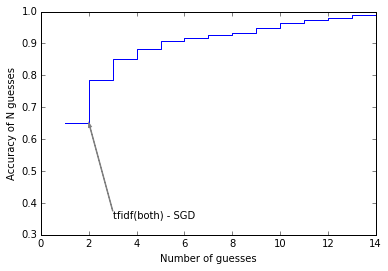

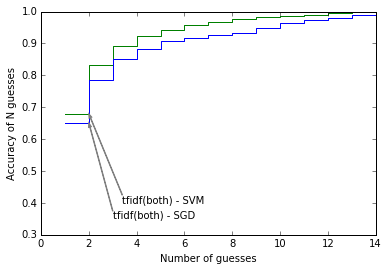

In [371]:
colors = ['b','g','r','c','y','k', 'lightsalmon', 'orange', 'orchid']
    
for i in range(len(clfs)):
    f = plt.figure()
    lines = [
        plt.step(range(1, len(accuracies[j])+1),accuracies[j], c = colors[j], where='post')[0]
        for j in range(i, -1, -1)
    ]
    plt.ylim((0.3, 1))
    plt.xlim(0, len(accuracies[0]))
    plt.ylabel('Accuracy of N guesses')
    plt.xlabel('Number of guesses')
    for a, c, i in zip(accuracies, clfs, range(len(accuracies[0])))[:i+1]:
        tx = 3+i*0.4
        ty = 0.35 +i*0.05
        text = c.name
        props = dict(color='gray', shrink=0.0, frac=0.05, width=0.5, headwidth=3)
        plt.annotate(text, xy = (2, a[0]), xytext=(tx, ty), arrowprops = props)
        
    plt.savefig('classifier-n-guesses_{}.pdf'.format(i+1), bbox_inches='tight')
    plt.show()


### Get Bag-Of-Words examples

In [51]:
d, c, m, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")
#d, c, m, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
[i for i, q in enumerate(meta) if 'skinet' in q[0]]

print "BODY"
arr = sorted([(d[w], int(count)) for w, count in c[185]])
print ", ".join("{}~({})".format(w, c) for w, c in arr)

print "META"
arr = sorted([(d[w], int(count)) for w, count in m[185]])
print ", ".join("{}~({})".format(w, c) for w, c in arr)


Done.
BODY
101~(1), 1949~(1), 1968~(1), 2015~(2), 31~(1), 66~(2), abus~(2), acl~(1), activ~(1), advic~(1), aid~(1), airbag~(1), aliv~(1), audienc~(1), avalanch~(2), bar~(1), bay~(1), bc~(1), big~(1), blow~(1), brave~(1), break~(1), british~(1), bum~(1), champ~(1), code~(1), columbia~(1), compani~(1), copyright~(1), crack~(1), creat~(1), cruz~(1), deepest~(1), dream~(1), elk~(1), enjoy~(1), entertain~(1), excit~(1), exot~(1), explor~(1), famili~(1), film~(2), financi~(2), fli~(1), friend~(1), gear~(2), goal~(1), grand~(1), great~(1), group~(1), hotel~(1), idea~(2), inspir~(1), interest~(1), jump~(1), lab~(1), largest~(1), latest~(1), lifetim~(1), locat~(2), luxuri~(1), magazin~(5), massiv~(1), media~(1), meet~(1), midwest~(1), miller~(4), mountain~(2), network~(1), nevada~(1), organ~(1), perform~(1), polici~(1), powder~(2), privaci~(1), publish~(1), race~(1), record~(1), recreat~(1), region~(1), reno~(1), review~(1), safer~(1), scene~(1), servic~(1), set~(1), shot~(1), ski~(13), skier~(

### See some examples of misclassified websites

In [269]:
A = np.array([[1, 2, 3], [4, 5, 6]])
B = np.array([[2, 3], [4, 5, 5]])

print A.T * B

[[[2, 3] [4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5]]
 [[2, 3, 2, 3] [4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5]]
 [[2, 3, 2, 3, 2, 3] [4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5]]]


In [315]:
inspector = analysis.ExampleInspector(dictionary, clf, X_test, y_test, predicted, meta, ind_test, dmoz_encoder)

In [322]:
inspector.get_confusion(13, 11, 1)

samples of class 'society' predicted as 'science'

http://acsh.org/ society, issues, health
Predicted as: science, health, society
Science words: scienc, 2009, 2013, novemb, 2007, 2011, juli, 2008, 2006

http://www.angelfire.com/ca5/ancientgreecescience/ society, history, by topic
Predicted as: science, society, arts
Science words: scienc, astronomi, scientist, scientif, contribut, ancient, background, melayu, wedg

http://www.iwitts.org/ society, people, women
Predicted as: science, society, kids and teens
Science words: scienc, stem, institut, engin, math, technolog, student, webinar, project

http://www.engineergirl.org/ society, people, women
Predicted as: science, computers, business
Science words: engin, scienc, depart, environment, professor, project, mechan, sky, student

http://www.bbc.co.uk/history/british/empire_seapower/jardineih_01.shtml society, history, by topic
Predicted as: science, news, reference
Science words: scienc, scientif, mathemat, astronom, chemistri, earth, 

In [323]:
inspector.get_confusion(13, 9, 1)

samples of class 'society' predicted as 'reference'

http://biography.jrank.org/ society, people
Predicted as: reference, society, arts
Reference words: biographi, student, robert, famou, paul, graham, archiv, sandra, frank

http://www.webexhibits.org/calendars/ society, history, by topic
Predicted as: reference, arts, science
Reference words: calendar, word, museum, exhibit, book, refer, earth, schedul, observ

http://aac.sub.uni-goettingen.de/en/history/guide/ society, history
Predicted as: reference, regional, arts
Reference words: librari, subject, histori, literatur, cultur, catalogu, search, guid, scholarli

http://www.historicaltextarchive.com/ society, history
Predicted as: reference, recreation, regional
Reference words: archiv, genealog, histor, book, subject, collect, histori, map, united st

http://labordoc.ilo.org/ society, work
Predicted as: reference, regional, news
Reference words: librari, thesauru, journal, 1, librarian, search, e-journ, book, tokyo

http://library.du

<function lib.jsoncorpus.process_html>

In [12]:
import urllib2

fullclf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc', class_weight='auto')
fullclf.fit(X, classes)

Pipeline(steps=[('selection', ItemPicker(index=2)), ('feature', Pipeline(steps=[('tfidf', TFIDFModel(id2word=None)), ('matrix', TopicMatrixBuilder(keep_all=True, num_topics=13021, topic_min_members=0))])), ('classifier', LinearSVC(C=0.08, class_weight='auto', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [41]:

response = urllib2.urlopen('http://www.apple.com')
html = response.read()

processed = jsoncorpus.process_html(html)
words = processed[0] + list(itertools.chain.from_iterable(processed[1].values()))
stopped = (word for word in words if word not in datastuff.stoplist)
stemmed = list(jsoncorpus.stem_words(stopped))
doc = dictionary.doc2bow(stemmed)

d = [doc, doc, doc]
probas = fullclf.predict_proba([d]) if hasattr(fullclf,'predict_proba') else fullclf.decision_function([d])
preds = np.fliplr(np.argsort(probas))
print dmoz_encoder.inverse_transform(preds)[0][:3]
#print fullclf.predict_proba([d])
print np.sort(probas[0])[::-1][:3]

weights = fullclf.steps[2][1].coef_
transformed = Pipeline(fullclf.steps[:2]).transform([d])
trf = transformed[0] * weights[preds[0][1]]
inds = np.argsort(trf)[::-1]
best = [dictionary[i] for i in inds][:9]
print ", ".join(best)
trf = transformed[0] * weights[preds[0][0]]
inds = np.argsort(trf)[::-1]
best = [dictionary[i] for i in inds][:9]
print ", ".join(best)

[u'computers' u'shopping' u'recreation']
[-0.76173585 -0.86332387 -0.90329331]
store, appl, shop, retail, ad, notebook, onlin, tv, iphon
appl, comput, os, mac, desktop, io, search, design, itun


In [24]:
joblib.dump(fullclf, 'classifier.pkl') 

['classifier.pkl',
 'classifier.pkl_01.npy',
 'classifier.pkl_02.npy',
 'classifier.pkl_03.npy']

In [27]:
loadclf = joblib.load('classifier.pkl')

0.0984570980072
